In [1]:
!  git config --global user.email "khayam.gondal@gmail.com"
!  git config --global user.name "Khayam Gondal"
!  git pull

Already up to date.


In [5]:
! pip install xformers git+https://github.com/huggingface/accelerate.git -q
! pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118 -q
! pip install git+https://github.com/huggingface/diffusers -q
! pip install git+https://github.com/huggingface/transformers -q
! pip install opencv-contrib-python controlnet_aux -q


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.13.1+cu116 requires torch==1.12.1, but you have torch 2.0.1 which is incompatible.
torchaudio 0.12.1+cu116 requires torch==1.12.1, but you have torch 2.0.1 which is incompatible.


In [6]:
!pip freeze | grep torch

torch==2.0.1
torchaudio==2.0.2+cu118
torchvision==0.15.2+cu118


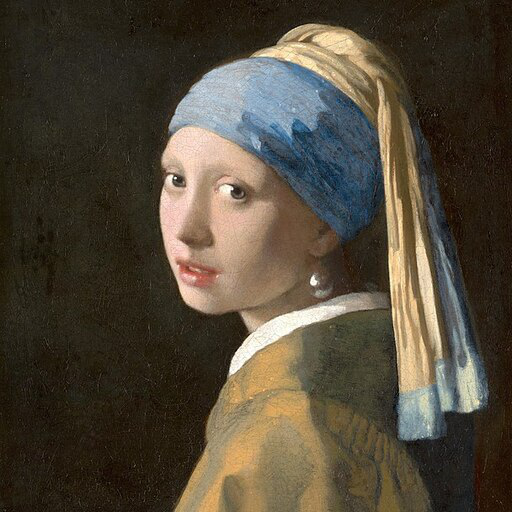

In [9]:
from diffusers.utils import load_image

image = load_image(
    "https://hf.co/datasets/huggingface/documentation-images/resolve/main/diffusers/input_image_vermeer.png"
)
image

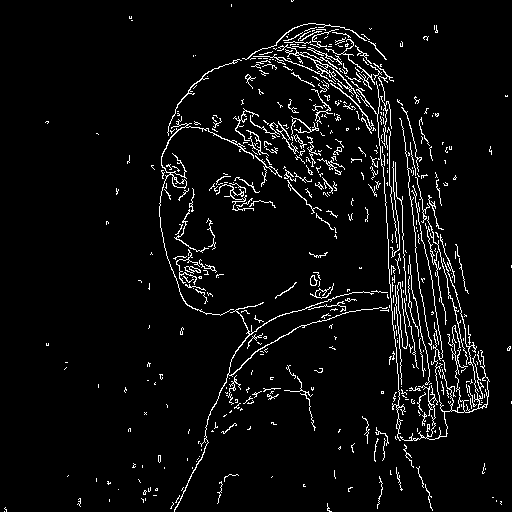

In [10]:
import cv2
from PIL import Image
import numpy as np

image = np.array(image)

low_threshold = 100
high_threshold = 200

image = cv2.Canny(image, low_threshold, high_threshold)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)
canny_image = Image.fromarray(image)
canny_image

In [11]:
%env HF_HOME = /storage/hf
%env HF_DATASETS_CACHE=/storage/hf/datasets
%env TRANSFORMERS_CACHE=/storage/hf/models

from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
import torch

controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=controlnet, torch_dtype=torch.float16
)
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

pipe.enable_model_cpu_offload()
pipe.enable_xformers_memory_efficient_attention()




env: HF_HOME=/storage/hf
env: HF_DATASETS_CACHE=/storage/hf/datasets
env: TRANSFORMERS_CACHE=/storage/hf/models


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


In [12]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows * cols

    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

  0%|          | 0/20 [00:00<?, ?it/s]

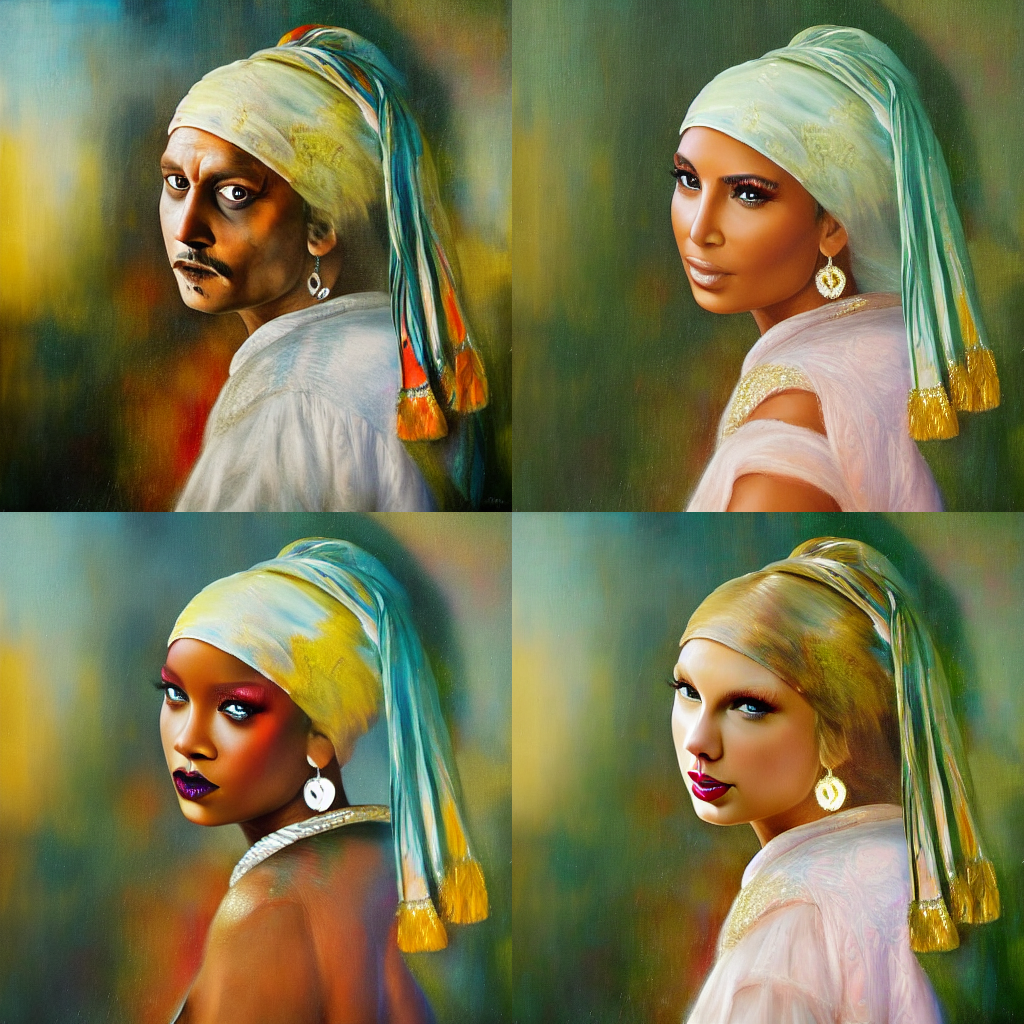

In [16]:
prompt = ", best quality, extremely detailed"
prompt = [t + prompt for t in ["Johnny Depp", "Kim Kardashian", "rihanna", "taylor swift"]]
generator = [torch.Generator(device="cpu").manual_seed(2) for i in range(len(prompt))]

output = pipe(
    prompt,
    canny_image,
    negative_prompt=["monochrome, lowres, bad anatomy, worst quality, low quality"] * 4,
    num_inference_steps=20,
    generator=generator,
)

image_grid(output.images, 2, 2)


In [ ]:
! git commit -a -m "updated notebook via paperspace"
! git push
! git status

[main 4bb85ad] updated notebook via paperspace
 2 files changed, 328 insertions(+), 19 deletions(-)
 create mode 100644 AutoTrain_Dreambooth.ipynb
